In [155]:
import os, csv, torch, scipy.io, torchvision.transforms, PIL.Image
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode
from collections import Counter
import matplotlib.pyplot as plt
import cv2
import urllib.request
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import requests
import os
from PIL import Image
from io import BytesIO
import time
import re
import nltk
from nltk.stem import WordNetLemmatizer
import tensorflow

In [156]:
model_weights = 'pretrained_seg_model/ckpt/ade20k-resnet50dilated-ppm_deepsup/'

if not os.path.exists(model_weights):
    os.makedirs(model_weights)

# Check if folder is empty
if not os.listdir(model_weights):
    print("Folder is empty, downloading weights...")
    # Define the download function
    def download_weights(url, filename):
        with tqdm(unit='B', unit_scale=True, unit_divisor=1024, miniters=1, desc=filename) as t:
            urllib.request.urlretrieve(url, model_weights + filename, reporthook=lambda blocks, block_size, total_size: t.update(block_size))

    # Download the encoder weights
    encoder_url = 'http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth'
    encoder_filename = 'encoder_epoch_20.pth'
    download_weights(encoder_url, encoder_filename)

    # Download the decoder weights
    decoder_url = 'http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth'
    decoder_filename = 'decoder_epoch_20.pth'
    download_weights(decoder_url, decoder_filename)

    print("Weights downloaded successfully!")
else:
    print("Folder is not empty, skipping weight download.")


Folder is not empty, skipping weight download.


In [157]:
colors = scipy.io.loadmat('pretrained_seg_model/data/color150.mat')['colors']
names = {}
with open('pretrained_seg_model/data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")

In [158]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='pretrained_seg_model/ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='pretrained_seg_model/ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cpu()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

In [159]:
def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(np.uint8)

    # aggregate images and save
    im_vis = np.concatenate((img, pred_color), axis=1)
    display(Image.fromarray(im_vis))

In [198]:
import matplotlib.pyplot as plt

def visualize_array(images_array):
    '''
        Takes an array of images and visualizes them in a grid of 4x4 or 3x3
    '''
    n = int(len(images_array)**0.5)
    fig, axs = plt.subplots(n, n, figsize=(10, 10))
    axs = axs.ravel()
    for i in range(len(images_array)):
        axs[i].imshow(images_array[i])
        axs[i].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


In [160]:
def img_to_arr(image, n):
    '''
        Takes the path to an image and n, the number of rows and columns in the grid
        Returns an array of n**2, h/n x w/n images
    '''
    # Convert the image to a numpy array
    image_array = np.array(image)
    h, w, c = image_array.shape
    # Split the image array into n**2 h/n x w/n sections
    sections = []
    for i in range(n):
        for j in range(n):
            section = image_array[i*h//n:(i+1)*h//n, j*w//n:(j+1)*w//n]
            sections.append(section)
    # Convert the sections list to a numpy array
    sections_array = np.array(sections)
    return sections_array

In [161]:
def create_grid_pred(arr, n):
    '''
        Takes an array of predictions and n, the number of rows and columns in the grid
        Returns an n x n grid of predictions
    '''
    h, w = arr.shape[:2]
    grid_h, grid_w = n, n
    sub_h, sub_w = h // grid_h, w // grid_w
    grid = np.zeros((grid_h, grid_w, sub_h, sub_w) + arr.shape[2:], dtype=arr.dtype)
    for i in range(grid_h):
        for j in range(grid_w):
            sub_arr = arr[i*sub_h:(i+1)*sub_h, j*sub_w:(j+1)*sub_w]
            grid[i, j] = sub_arr
    return grid

In [162]:
def visualize_captcha_solution(input_img, output_list, n, look_for):
    '''
        Takes the path to an image, the output list from solve_3_x_3 or solve_4_x_4, the number of rows and columns in the grid, and the name of the object to look for
    
        Returns a visualization of the predictions for each square.
    '''
    array_img = img_to_arr(input_img, n)
    fig, ax = plt.subplots(n, n, figsize=(8, 8))
    fig.suptitle(f'Looking for {look_for}', fontsize=16)
    for i, axi in enumerate(ax.flat):
            axi.imshow(array_img[i])
            if output_list[i]:
                axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='g', facecolor='none'))
            else:
                axi.add_patch(plt.Rectangle((0, 0), array_img[i].shape[1], array_img[i].shape[0], linewidth=15, edgecolor='r', facecolor='none'))
            axi.set(xticks=[], yticks=[])
    plt.show()

In [202]:
def solve_3_x_3(img_array, target_name, confidence, debug=False):
    '''
        Solves a 3x3 recaptcha image.
        img_path: The path to the image to solve.
        target_name: The name of the target class. E.g. "stairs" Target class should be in the 150 classes of the MIT dataset.
        confidence: The confidence threshold. The function will append 'True' if the target class is within the top 'confidence' predictions.
        debug: If True, will visualize the predictions for each square.

        Returns 
            pred_df: A dataframe of the predictions for each square.
            output_list: A list of booleans. True if the target class is in the top 'confidence' predictions for that square. False otherwise.
    '''

    # Define the transformation to apply to each image
    pil_to_tensor = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
            std=[0.229, 0.224, 0.225])  # across a large photo dataset.
    ])

    # Define the output list to return
    output_list = []
    # Define the dictionary of predictions to return
    pred_dict = {}
    # Iterate over each image in the array
    enumerate(img_array)
    for idx, img in enumerate(img_array):
        # Convert the image to a tensor and apply the transformation
        pil_image = Image.fromarray(img)
        img_data = pil_to_tensor(pil_image)
        singleton_batch = {'img_data': img_data[None].cpu()}

        # Run the segmentation model on the image
        with torch.no_grad():
            scores = segmentation_module(singleton_batch, segSize=img_data.shape[1:])
        _, pred = torch.max(scores, dim=1)
        pred = pred.cpu()[0].numpy()

        # Visualize the predictions
        if debug:
            visualize_result(img, pred)

        # Check if the target class is present in the image
        target_class = -1
        for i in range(len(names)):
            if target_name in names[i+1]:
                target_class = i
                break
        if target_class == -1:
            raise ValueError('Target class not found in the class names.')
        
        top_preds = np.argsort(np.bincount(pred.flatten()))[::-1][:confidence]
        top_classes = [names[i+1] for i in top_preds]
        is_present = target_class in top_preds
        
        output_list.append(is_present)
        pred_dict[idx] = {f'Pred #{str(i+1)}': val for i, val in enumerate(top_classes)}
        
    pred_df = pd.DataFrame(pred_dict)
    return output_list, pred_df


In [201]:
def solve_4x4(image, target_name, confidence):
    '''
        Solves a 4x4 recaptcha image.
        img_path: The path to the image to solve.
        target_name: The name of the target class. E.g. "stairs" Target class should be in the 150 classes of the MIT dataset.
        confidence: The confidence threshold. The function will append 'True' if the target class is within the top 'confidence' predictions.
        debug: If True, will visualize the predictions for each square.

        Returns 
            pred_df: A dataframe of the predictions for each square.
            output_list: A list of booleans. True if the target class is in the top 'confidence' predictions for that square. False otherwise.
    '''

    # Define the transformation to apply to the image
    pil_to_tensor = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
            std=[0.229, 0.224, 0.225])  # across a large photo dataset.
    ])

    # Define the output list to return
    output_list = []
    # Define the dictionary of predictions to return
    pred_dict = {}

    # Convert the image to a numpy array
    img_original = np.array(image)
    # Convert the image to a tensor
    img_data = pil_to_tensor(image)
    # Create a singleton batch
    singleton_batch = {'img_data': img_data[None].cpu()}
    # Get the output size
    output_size = img_data.shape[1:]

    # Run the segmentation at the highest resolution.
    with torch.no_grad():
        scores = segmentation_module(singleton_batch, segSize=output_size)

    # Get the predicted scores for each pixel
    _, pred = torch.max(scores, dim=1)
    pred = pred.cpu()[0].numpy()

    # Create a grid of predictions
    pred_grid = create_grid_pred(pred, 4)

    for r in range(4):
        for c in range(4):
            # Get the prediction for the current square
            pred = pred_grid[r][c]
            # Check if the target class is present in the image
            target_class = -1
            for i in range(len(names)):
                if target_name in names[i+1]:
                    target_class = i
                    break
            if target_class == -1:
                raise ValueError('Target class not found in the class names.')
            
            top_preds = np.argsort(np.bincount(pred.flatten()))[::-1][:confidence]
            top_classes = [names[i+1] for i in top_preds]
            is_present = target_class in top_preds
            
            output_list.append(is_present)
            pred_dict[f'{r},{c}'] = top_classes

    # Get maximum length of arrays in pred_dict
    max_len = max(len(v) for v in pred_dict.values())
    # Pad shorter arrays with NaN values
    d_padded = {k: v + [np.nan]*(max_len - len(v)) for k, v in pred_dict.items()}
    # Convert to dataframe
    pred_df = pd.DataFrame.from_dict(d_padded)
    return output_list, pred_df


In [165]:
import pickle
with open('captcha_type.pickle', 'rb') as file:
    captcha_type_model = pickle.load(file)

In [166]:
def decode_label(label):
    class_names = ['letters', 'nonsegmentation', 'segmentation']
    return class_names[label]

In [167]:
nltk.download('wordnet')

def parse_target(filename):
    pattern = r"(?:a )?([\w\s]+)(?:_\d+)?(?:\.(png|jpg|jpeg))?$"
    match = re.search(pattern, filename)
    if match:
        noun = match.group(1)
        noun = WordNetLemmatizer().lemmatize(noun)
        return noun
    else:
        print("No noun found in the file name.")
        return "Not found"



[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jamescavallo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [168]:
def target_present(target):
    return target in [val for sublist in names.values() for val in sublist]

In [169]:
#If there are images to replace we will replace them
def replace_images(img_array, to_replace, new_images):
    if len(new_images) == 0:
        return
    count = 0
    for idx in to_replace:
        print("Replaced image at " + str(idx))
        img_array[idx] = np.array(new_images[count])
        count +=1


## Main Pipeline Begins Here

In [199]:
def pipeline(image, label, pred_type, to_replace, new_images):
    confidence =  10
    target = parse_target(label)
    print("Target", target)
    if not target_present(target):
        print(target, "is not found in our classes")
        return (False, False)
    pil_image = image.convert('RGB')
    
    if pred_type == "nonsegmentation":
        img_array = img_to_arr(pil_image, 3) #pass the image array to solve 3x3 instead of the grid image
        if new_images is not None:
            replace_images(img_array, to_replace, new_images)
        visualize_array(img_array)
        output_list, pred_df = solve_3_x_3(img_array, target, confidence)
        return output_list, pred_df
    elif pred_type == "segmentation":
        output_list, pred_df = solve_4x4(pil_image, target, confidence)
        return output_list, pred_df
    else:
        print("Letters detected")
        return (False, False)

In [171]:
import random
def scrape_image(driver, wait):
    print("scraped captcha grid")

    driver.switch_to.default_content()
    challenge_iframe = wait.until(EC.frame_to_be_available_and_switch_to_it((By.CSS_SELECTOR, 'iframe[title="recaptcha challenge expires in two minutes"]')))   
    image = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'img[src*="api2/payload"]')))

    image_src = image.get_attribute('src')


    label = driver.find_element(By.TAG_NAME, 'strong').text

    response = requests.get(image_src)

    image_content = response.content

        # Open the image from bytes
    image = Image.open(BytesIO(image_content))
    
    return image, label

In [172]:
def scrape_replaced_images(driver):
    elements = driver.find_elements(By.CLASS_NAME, 'rc-image-tile-11')
    new_images = []
    for image_element in elements:
        image_src = image_element.get_attribute('src')
        response = requests.get(image_src)
        image_content = response.content
        image = Image.open(BytesIO(image_content))
        new_images.append(image)
    return new_images

In [188]:
def drive_3x3(driver, image, label, pred_type, click_delay, wait):
    output_list, pred_df = pipeline(image, label, pred_type, None, None)
    if output_list == False:
        return False
    print("original predictions", output_list)

    while (True in output_list):
        elements = driver.find_elements(By.CLASS_NAME, 'rc-imageselect-tile')
        idx = 0
        to_replace = []
        for element in elements:
            if output_list[idx]:
                element.click()
                time.sleep(click_delay)
                to_replace.append(idx)
            idx +=1
        time.sleep(6.0) #wait for all new images to fade in and retry
        new_images = scrape_replaced_images(driver)

        new_image, new_label = scrape_image(driver, wait) 
        output_list, pred_df = pipeline(new_image, new_label, "nonsegmentation", to_replace, new_images)
        print(output_list)
        print("One 3x3 Passthrough complete") 
        

    verify_button = driver.find_element(By.ID, 'recaptcha-verify-button')
    verify_button.click()
    return True

        

In [187]:
def drive_4x4(driver, image, label, pred_type, click_delay):
        #predict on our scraped captcha
        output_list, pred_df = pipeline(image, label, pred_type, None, None)
        if output_list == False:
            return False

        # Find all elements with class name "rc-imageselect-tile"
        elements = driver.find_elements(By.CLASS_NAME, 'rc-imageselect-tile')
        print("output", output_list)
            
        idx = 0
        for element in elements:
            if output_list[idx]:
                element.click()
                time.sleep(click_delay)
            idx +=1

        verify_button = driver.find_element(By.ID, 'recaptcha-verify-button')
        verify_button.click()
        return True

Starting Solve
scraped captcha grid
1/1 [==============================] - 0s 25ms/step
4x4 segmentation detected
Target motorcycle
motorcycle is not found in our classes
scraped captcha grid
1/1 [==============================] - 0s 25ms/step
4x4 segmentation detected
Target motorcycle
motorcycle is not found in our classes
scraped captcha grid
1/1 [==============================] - 0s 25ms/step
3x3 nonsegmentation detected
Target car


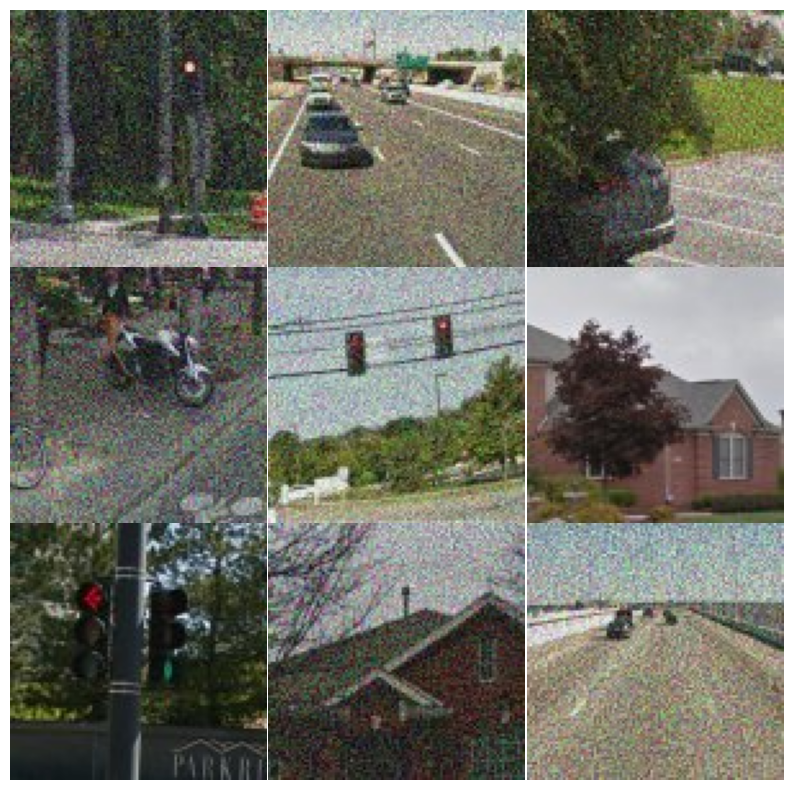

original predictions [False, False, True, False, False, False, False, False, False]
scraped captcha grid
Target car
Replaced image at 2


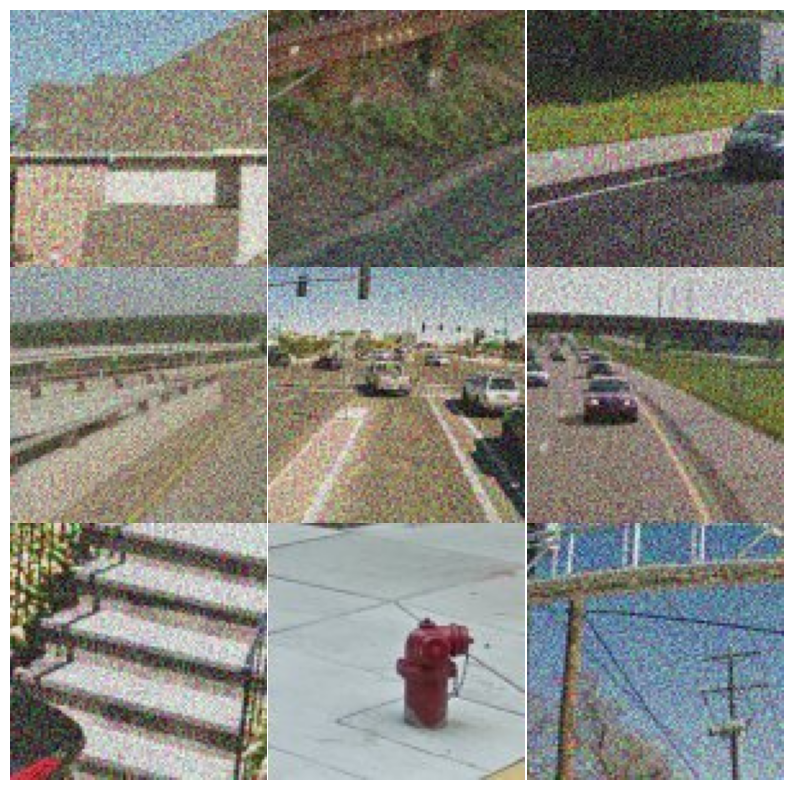

[False, False, False, False, True, True, False, False, False]
One 3x3 Passthrough complete
scraped captcha grid
Target car
Replaced image at 4
Replaced image at 5


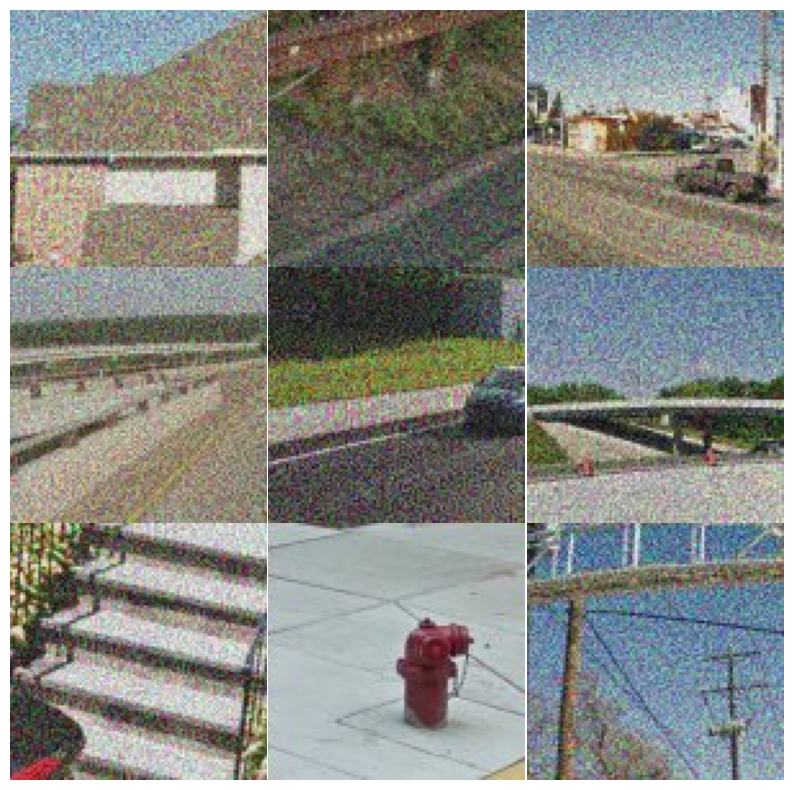

[False, False, False, False, False, False, False, False, False]
One 3x3 Passthrough complete
3x3 complete
scraped captcha grid
1/1 [==============================] - 0s 29ms/step
3x3 nonsegmentation detected
Target car


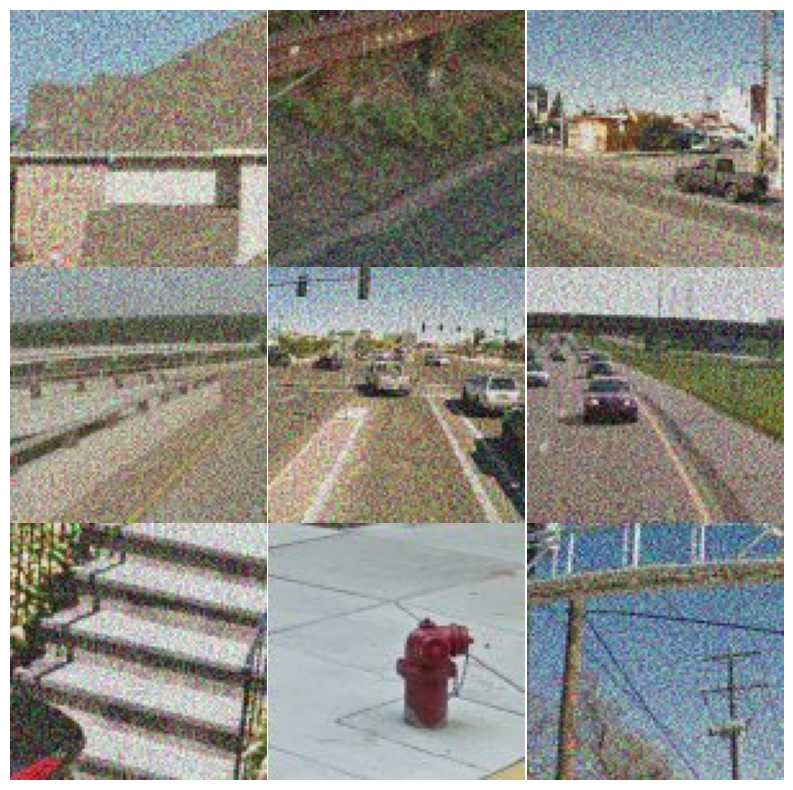

original predictions [False, False, False, False, True, True, False, False, False]
scraped captcha grid
Target motorcycle
motorcycle is not found in our classes
False
One 3x3 Passthrough complete


TypeError: argument of type 'bool' is not iterable

In [208]:
captcha_site = 'https://www.google.com/recaptcha/api2/demo'
click_delay = .5
solved = False

# create a new instance of the Chrome browser
driver = webdriver.Chrome()

# navigate to the website
driver.get(captcha_site)

# wait for reCAPTCHA iframe to load and switch to it
wait = WebDriverWait(driver, 10)
    # switch back to the main frame and wait for the "recaptcha challenge expires in two minutes" iframe to load
recaptcha_iframe = wait.until(EC.frame_to_be_available_and_switch_to_it((By.CSS_SELECTOR, 'iframe[title="reCAPTCHA"]')))

    # wait for div#rc-anchor-container to load and click on div.recaptcha-checkbox-border
recaptcha_wait = WebDriverWait(driver, 10)
recaptcha = recaptcha_wait.until(EC.presence_of_element_located((By.ID, 'rc-anchor-container')))
recaptcha.click()

print("Starting Solve")
while(not solved):
    # find the captcha image element and get its source and class name
    image, label = scrape_image(driver, wait)

    #convert it for predictions
    pil_image = image.convert('RGB')
    img_original = np.array(pil_image)
    img = cv2.resize(img_original, (120, 120))
    img = np.expand_dims(img, axis=0)

    captcha_type = captcha_type_model.predict(img)          
    pred_type = decode_label(np.argmax(captcha_type))

    if pred_type == "segmentation":
        print("4x4 segmentation detected")
        if not drive_4x4(driver, image, label, pred_type, click_delay):
            reload_button = driver.find_element(By.ID,'recaptcha-reload-button')
            print("Skipped")
            reload_button.click()
        else:
            print("4x4 complete") 
    elif pred_type == "nonsegmentation":
        print("3x3 nonsegmentation detected")
        if not drive_3x3(driver, image, label, pred_type, click_delay, wait):
            reload_button = driver.find_element(By.ID,'recaptcha-reload-button')
            print("Skipped")
            reload_button.click()
        else:
            print("3x3 complete") 
    else:
        print("Letters detected")
        #TODO Letter model goes here
        pass

# switch back to the main frame and quit the browser
driver.switch_to.default_content()
driver.quit()
